In [299]:
import pandas as pd
import math
from sklearn.impute import KNNImputer 

######################## PART 1 #####################################################
# 1. Time difference between peak after meal
def time_difference(record, start_index):
    filtered_record = record.iloc[:, start_index:]
    max_indices = filtered_record.idxmax(axis=1)
    column_positions = max_indices.map(lambda col: record.columns.get_loc(col))
    result = (column_positions - start_index) * 5
    return pd.DataFrame(result, columns=['time difference'])

# feature 2: glucose level difference after the meal (max glucose level - min glucose level)
def glucose_level_difference(record, start_index):
    max_indices = record.max(axis=1)
    meal_indices = record.iloc[:, start_index]
    result = (max_indices - meal_indices) / meal_indices
    return pd.DataFrame(result, columns=['glucose level difference'])


# 2. perform KNN to predict missing values
def knn_imputer(record):
    imputer = KNNImputer(n_neighbors=2)

    return pd.DataFrame(imputer.fit_transform(record), columns=record.columns)

# 1. Get rid of rows thats mising more that 5% of the data
def rid_rows_threshold(record):
    threshold = 0.05 # 5%
    empty_cell_count = record.isna().sum(axis=1)
    total_cells = record.shape[1]
    rows_to_keep = empty_cell_count / total_cells < threshold
    return record[rows_to_keep]

def getTrainingData(insulin_csv, cgm_csv):
    insulin_columns_to_read = ['Date', 'Time', 'BWZ Carb Input (grams)']
    df_insulin = pd.read_csv(insulin_csv, usecols=insulin_columns_to_read)
    df_insulin['Date'] = pd.to_datetime(df_insulin['Date'], errors='coerce').dt.date
    df_insulin['Date'] = df_insulin['Date'].astype(str)
    df_insulin['datetime'] = pd.to_datetime(df_insulin['Date'] + ' ' + df_insulin['Time'], errors='coerce')
    df_insulin = df_insulin.drop(columns=['Date', 'Time'])
    df_insulin = df_insulin.rename(columns={'BWZ Carb Input (grams)': 'meal'})
    df_insulin = df_insulin.dropna(subset=['meal'])
    df_insulin = df_insulin[df_insulin['meal'] != 0]
    df_insulin = df_insulin.sort_values(by='datetime').reset_index(drop=True)

    del insulin_columns_to_read

    meal_time = []
    carb = []
    # Loop through the DataFrame to find meal times with a > 2-hour gap
    for i in range(len(df_insulin) - 1):
        current_time = df_insulin['datetime'].iloc[i]
        next_time = df_insulin['datetime'].iloc[i + 1]

        if current_time + pd.Timedelta(hours=2) < next_time:
            meal_time.append(current_time)
            carb.append(df_insulin['meal'].iloc[i])

    cgm_columns_to_read = ['Date', 'Time', 'Sensor Glucose (mg/dL)']
    df_cgm = pd.read_csv(cgm_csv, usecols=cgm_columns_to_read)
    df_cgm = df_cgm.rename(columns={'Sensor Glucose (mg/dL)': 'glucose'})
    df_cgm['datetime'] = pd.to_datetime(df_cgm['Date'] + ' ' + df_cgm['Time'])
    df_cgm = df_cgm.drop(columns=['Date', 'Time'])
    df_cgm = df_cgm.sort_values(by='datetime').reset_index(drop=True)

    del cgm_columns_to_read

    # find datetime for Sugar Glucose Level based on meal time, ex(meal time = 9:00, SugarGlucose measured after meal = 9:03), make meal time = 9:03
    index = 0
    new_meal_time = []

    for i in range(len(df_cgm)):
        if (df_cgm['datetime'].iloc[i] > meal_time[index]):
            if (df_cgm['datetime'].iloc[i] < (meal_time[index] + pd.Timedelta(minutes=5))): # Edge case: meal time and glucose measure not with in 5 min
                new_meal_time.append(df_cgm['datetime'].iloc[i])
            else:
                if (len(new_meal_time) != len(carb)):
                    del carb[len(new_meal_time)]

            if (index < len(meal_time) - 1):
                index += 1

    meal_time = new_meal_time

    del new_meal_time
    del index

    # locate meal_time and add glucose level 30 min before and 2hr after meal_time, 30 data per row including meal_time glucose level
    total_glucose_data = 30 # 2hrs:30min / 5min
    num_glucose_before_meal = 6 # 30min / 5min

    meal_data = []
    for datetime in  meal_time:
        data = []
        index = df_cgm[df_cgm['datetime'] == datetime].index[0] - num_glucose_before_meal

        for row in range(index, index + total_glucose_data + 1):
            if (row < index + total_glucose_data):
                data.append(df_cgm.loc[row, 'glucose'])

        meal_data.append(data)

    del index
    del data

    column_names = [f'col{i+1}' for i in range(len(meal_data[0]))]
    meal_data = pd.DataFrame(meal_data, columns=column_names)
    #-----------------------------Meal data (ready)------------------------------------------------------
    return meal_data, carb

meal_data, carb = getTrainingData('InsulinData.csv', 'CGMData.csv')
meal_data['carb'] = carb
meal_data.reset_index(drop=True, inplace=True)

# Handling Missing data
meal_data = rid_rows_threshold(meal_data, carb)

# performing knn for 1st column is a bad idea because knn = 2
meal_data = meal_data.dropna(subset=['col1'])

#key to map points on bins and clusters
key = []
for i in range(len(meal_data)):
    key.append(i)

meal_data['key'] = key
carb = meal_data['carb', 'key'].copy()
meal_data.drop(columns=['carb'], inplace=True)

meal_data = knn_imputer(meal_data)
########################### Feature Extraction #####################################
time_difference_meal = time_difference(meal_data, 5)

# Decision tree (Feature 1: time difference)
time_difference_meal['target'] = 1

time_difference_data = time_difference_meal

# feature 2: glucose level difference
glucose_level_difference_meal = glucose_level_difference(meal_data, 5)

glucose_level_difference_meal['target'] = 1

glucose_level_difference_data = glucose_level_difference_meal
final_data = pd.concat([time_difference_data, glucose_level_difference_data], axis=1)
final_data.drop(columns='target', inplace=True)

print(len(final_data), len(carb))

480 480


In [300]:
#Step 1: Ground truth
class Bin: ##Discretize each rows/meal data, ex if meal data range from 0 - 20 gram of carb put it in bin 1, 21 - 40 in bin 2 and so on
    def __init__(self, id, min_range, max_range):
        self.id = id
        self.min_range = min_range
        self.max_range = max_range
        self.data = []

    def add_data(self, row):
        # Create column names if the DataFrame is empty
        if self.data.empty:
            column_names = [f'col{i+1}' for i in range(len(row) - 1)]
            column_names.append('carb')
            self.data = pd.DataFrame(columns=column_names)

        new_row = pd.DataFrame([row], columns=self.data.columns)

        self.data = pd.concat([self.data, new_row], ignore_index=True)

def create_bins(carb):
    num_of_bins = math.ceil((max(carb) - min(carb)) / 20)
    bins = []

    # Initialize bins
    for i in range(num_of_bins):
        if i == 0:
            min_range = 0
            max_range = 20
        else:
            min_range = (20 * i) + 1
            max_range = 20 * (i + 1)
    
        bins.append(Bin(i, min_range, max_range))
        
    return bins

bins = create_bins(carb)

for value in carb:
    if (value % 20) == 0:
        bin_index = math.floor(value / 20) - 1
    else:
        bin_index = math.floor(value / 20)

    bins[bin_index].data.append(value)


In [301]:
# Step 2 Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

clustering_data = final_data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(clustering_data)

kmeans = KMeans(n_clusters=len(bins), init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(x_scaled)

clustering_data['Cluster'] = kmeans.labels_

""" plt.figure(figsize=(10, 6))
plt.scatter(clustering_data['time difference'], clustering_data['glucose level difference'], c=clustering_data['Cluster'], cmap='viridis', marker='o', s=100)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

print(clustering_data) """

" plt.figure(figsize=(10, 6))\nplt.scatter(clustering_data['time difference'], clustering_data['glucose level difference'], c=clustering_data['Cluster'], cmap='viridis', marker='o', s=100)\ncentroids = scaler.inverse_transform(kmeans.cluster_centers_)\nplt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')\nplt.title('K-Means Clustering')\nplt.xlabel('Feature 1')\nplt.ylabel('Feature 2')\nplt.legend()\nplt.grid()\nplt.show()\n\nprint(clustering_data) "

In [304]:
kmeans_matrxi = pd.DataFrame(0, index=range(6), columns=range(6))

for bin in bins:
    

   0  1  2  3  4  5
0  0  0  0  0  0  0
1  0  0  0  0  0  0
2  0  0  0  0  0  0
3  0  0  0  0  0  0
4  0  0  0  0  0  0
5  0  0  0  0  0  0


Estimated number of clusters: 3, number of bins: 6
349 480


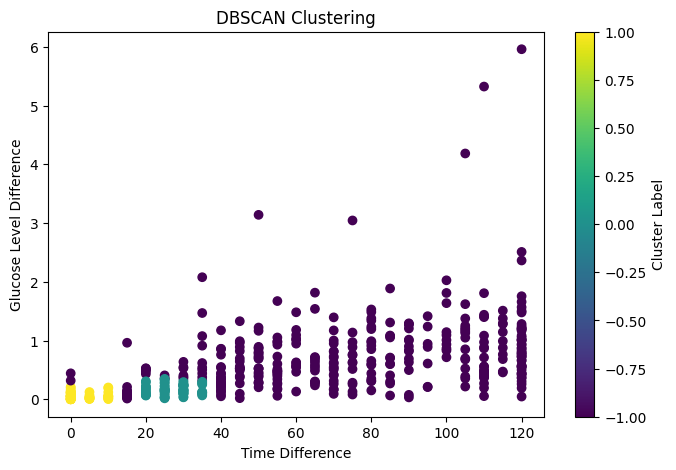

In [302]:
from sklearn.cluster import DBSCAN

def perform_dbscan(dbscan_data, eps_value, min_sample_value):
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(dbscan_data)

    dbscan = DBSCAN(eps=eps_value, min_samples=min_sample_value)
    dbscan.fit(x_scaled)

    dbscan_data['Cluster'] = dbscan.labels_

    # Calculate number of clusters
    n_clusters = len(set(dbscan_data['Cluster'])) - (1 if -1 in dbscan_data['Cluster'] else 0)
    
    noise_points = sum(dbscan.labels_ == -1)
    return dbscan_data, n_clusters, noise_points

final_data.drop(columns=['Cluster'], errors='ignore', inplace=True)

eps_val = 0.1
dbscan_data = final_data.copy()  # Create a copy to avoid modifying original data
n_clusters = 0
min_sample_value = 0
eps_value = 0

while eps_val <= 1:
    for i in range(30, 100, 10):
        dbscan_data_temp, num_cluster, noise_points = perform_dbscan(dbscan_data.copy(), eps_val, i)  # Use a copy
        if num_cluster > len(bins):  # Assuming bins is defined
            continue
        else:
            if num_cluster > n_clusters:
                n_clusters = num_cluster
                min_sample_value = i
                eps_value = eps_val
                
    eps_val += 0.1

# Perform final DBSCAN with the best parameters
dbscan_data, n_clusters, noise_points = perform_dbscan(final_data.copy(), eps_value, min_sample_value)
print(f'Estimated number of clusters: {n_clusters}, number of bins: {len(bins)}')
print(noise_points, len(dbscan_data))

# Plotting
plt.figure(figsize=(8, 5))
scatter = plt.scatter(dbscan_data['time difference'], dbscan_data['glucose level difference'], 
                      c=dbscan_data['Cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Time Difference')
plt.ylabel('Glucose Level Difference')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

In [303]:
# SSE for dbscan
mean_df = dbscan_data.groupby('Cluster').mean()
print(mean_df)    

         time difference  glucose level difference
Cluster                                           
-1             74.670487                  0.754754
 0             27.297297                  0.168246
 1              2.719298                  0.058390
